# This notebook runs through investigations of the 2D Ising model for J > 0, L = 10, and T = range(0.1,10.1,0.1). These parameters can easily be changed, but the notebook as it stands is designed such that one can run the notebook cell by cell in a reasonable amount of run time with commentary as each step.

Note that I switch between using matplotlib imported as "%matplotlib inline" for usual plotting, and "%matplotlib notebook" for the animations. One needs to make sure to end the animations before moving on, and occasionally jupyter notebook will encounter an error with the swtiching back and forth. Sometimes one needs to run the cell a few times, but occasionally this doesn't fix it, at which point one just needs to restart the kernel and try again. 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

class Direction:
    """
    Initialize directionality of 2D Ising model
    """
    Right, Top, Left, Bottom = range(4)
    
class Ising2D(object):
    """
    Initialize 2D Ising object on which we will apply the metropolis algorithm
    """
    def __init__ (self, L, J, KbT, h):
        
        """
        Initialize Ising quantities and structure (Kb = 1) 
        """
        self.L = L # Length of 2D model (in points)
        self.N = L**2 # Total number of points in Ising model
        self.KbT = KbT# Thermal Energy (Joules) 
        self.beta = 1./KbT # For convenience, define beta = 1/[J]
        self.J = J # Exchange Constant J - for J > 0 aligned spins are favored, and visa versa
        self.h = h #Uniform external magnetic field strength
        
        #Initialize all spin positions, and makes sure they are integer valued:
        self.positions = np.zeros((self.L,self.L),dtype=np.int32)
        self.x = np.zeros(self.N,dtype=np.int32)
        self.y = np.zeros(self.N,dtype=np.int32)
        
        #Initialize the nearest neighbors for each position:
        self.nn = np.zeros((self.N,4),dtype=np.int32)
        
        """
        Initialize nearest neighbors and impose BC's
        """
        
        k = 0
        #**? changed these from being x_k <-> y_k - This fixed it
        for y_k in range(L):
            for x_k in range(L):
                #Define positions
                self.positions[y_k,x_k] = k
                self.x[k] = x_k
                self.y[k] = y_k
                #Define nearest neighbors
                self.nn[k,Direction.Left] = k-1
                self.nn[k,Direction.Right] = k+1
                self.nn[k,Direction.Bottom] = k-L
                self.nn[k,Direction.Top] = k+L # k plus whole row
                
                #Implement Periodic Boundary Conditions for nn:
                
                #**? Changed these fromg being += statements
                if x_k == 0: #when at leftmost side of grid:
                    
                    # Shift left nn to rightmost side of grid +(L col spaces)
                    self.nn[k,Direction.Left] += L # or (k-1)+L
                    
                if x_k == L-1: #when at rightmost side of grid:
                    
                    # Shift right nn to leftmost side of grid -(L col spaces)
                    self.nn[k,Direction.Right] -= L # or (k+1)-L
                    
                if y_k == 0: #when at bottom of grid:
                    
                    # Shift bottom nn to top of grid, +(L cols over)*(L rows up)
                    self.nn[k,Direction.Bottom] += L**2 # or (k-L)+L**2 
                    
                if y_k == L-1: #when at top of grid:
                    
                    # Shift top nn to bottom of grid, -(L cols over)*(L rows down)
                    self.nn[k,Direction.Top] -= L**2 # or (k+L)-L**2
                    
                k += 1   #advance to next iteration
                
                
        """
        Now we Initialize spins, magnetization, and transition probabilities
        """  
        
        
        rand = 2*np.random.random(self.N)-1 #randomly distributed from 0-1 so shift down so avg val is 0.
        
        #We can default to a random configuration of spins (can always be reset later)
        self.spins = np.ones(self.N, dtype=np.int32)
        for i in range(self.N):
            if (rand[i] < 0):
                self.spins[i] *= -1 #flip the spin
                
        self.M_total = np.sum(self.spins) # Def of Magnetization
        
        self.E = 0. # Initialize energy to 0
        for i in range(self.N):
            #sum up total energy contributed by each spin
            #Note importantly that we only sum over the right and top spins. This is so that we don't end up counting the same interaction twice
            self.E += -self.J*self.spins[i]*(self.spins[self.nn[i,Direction.Right]]+self.spins[self.nn[i,Direction.Top]])
        #Add energy contributed by uniform external magnetic field
        self.E += -self.h*self.M_total
            
        """
        Now we initialize matrices where we will store all possible dE's and then all possible Boltzmann Probabilities: BP. 
        This will allow us to avoid calculating them each iteration.
        
        We then can then create a function whose purpose is to calculate these quantities for a give temperature.
        I will call this Temp(), and it will also serve the purpose of setting self.T
        """ 
        
        self.dE = np.zeros((3,9)) 
        self.RP = np.zeros((3,9))  
        self.ThermE(self.KbT)
        
    def ThermE(self,KbT):
        
        self.KbT = KbT
        self.beta = 1./(KbT)
        
        #Next we populate the dE and Boltzmann Probability (BP) matrices (Commonly denoted as W):
        for i in range(-4,5): 
            #deltaU is 2*U, negative when spin in question is -1, positive when spin is +1.
            #We first setup the coefficients for the nearest-neighbor interaction energies
            #We can just use these, plus the dE from the mag field (added later) to determine the initial flip condition
            self.dE[0,i+4] = 2.*self.J*i
            self.dE[2,i+4] = -2.*self.J*i
            p_temp = np.exp(-self.beta*self.dE[0,i+4])
            #Note the (-) in the exponential of p_temp, so dE is E_init - E_trial, RelProb (RP) = P_trial/P_initial
            #If this is greater than a uniform random number, we will accept the new trial configuration
            
            #Now we will define the relative probailities which will determine the random number flip condition; We can cap probabilities at 1.
            if p_temp < 1.:
                self.RP[0,i+4] = p_temp
                self.RP[2,i+4] = 1./p_temp
            else:
                self.RP[2,i+4] = 1.
                self.RP[0,i+4] = 1.
                
    """
    We will now implement the Metropolis algorithm
    """
    
    def Metropolis(self):
        #initialize the number of configuration changes
        n_config_changes = 0
        
        for n in range(self.N):
            #Begin by generating a trial configuration
            #First we choose a random lattice point, k (and force it to be an integer)
            #We do this by generating a uniform random number and multiplying that by the total number of lattice points 
            k = int(np.random.random()*self.N)
            
            #Next, we define the nearest neighbors for k
            k_right = self.nn[k,Direction.Right]
            k_left = self.nn[k,Direction.Left]
            k_top = self.nn[k,Direction.Top]
            k_bot = self.nn[k,Direction.Bottom]
            
            #Next compute the sum of the nearest neighbor's spins, and flip the spin we're at (trial)
            spins_sum = self.spins[k_right]+self.spins[k_left]+self.spins[k_top]+self.spins[k_bot]
            s = self.spins[k]
            
            #flip spin for trial
            s *= -1 
            #Now we compute the change in nearest-neighbor energy from our dE matrix
            
            #It should be clear now why the dE matrix was 3x9 rather than 2x9 (spin will be -1 or 1, leading this to pick out rows 1 or 3)
            deltaE = self.dE[s+1,spins_sum+4]
            
            #Access the relative boltzmann probability from the RP matrices
            RelProb = self.RP[s+1,spins_sum+4]
            
            #Now we can add the energy change contributed by the uniform mag field interaction with the spin change
            
            h_deltaE = self.h*(2*s)
            
            deltaE += h_deltaE
            
            #Add energy change contribution from mag field to relative probability

            RelProb *= np.exp(-self.beta*h_deltaE)
            
            #spin flip is accepted if either dE <= 0 or if a uniformly distributed random number is smaller than the relative boltzmann probability
            if deltaE <=0. or RelProb > np.random.random():
                #accept spin flip
                self.spins[k] = s
                #update total magnetization after new spin
                self.M_total += 2*s
                #update total energy with energy change
                self.E += deltaE
                #add a counter to the number of configuration changes
                n_config_changes += 1
        return n_config_changes
# Define time functions to keep track of runtime
from time import time
tstart_list=[]

def tick():
    tstart_list.append(time())
    
def toc():
    print("Time Passed:",time()-tstart_list.pop(),"s") #.pop() is a nice way to grab the last element of your list

First let's run a test simulation. I find it crucial to point out that when running the Metropolis algorithm, we are assuming each new generated state to be independent from the last. In order to accomplish this numerically, I will run the Metropolis algorithm three times for each iteration of my simulation and only consider the final configuration as the next trial system; the first two configurations serve the purpose of decorrelating the 3rd from the initial. 

In [2]:
"""
Here we will initialize an Ising model with L = 10. 
We then run the metropolis algorithm for 100 runs with 1000 steps each
"""
tick()

#L = 10, Run the metropolis algorithm with 1000 steps
L = 10
N_Lattice = L*L #number of lattice sites
N_Iterations = 1000 # Number of times to run 
N_deCorrelation = 3 # Number of times to run metropolis algorithm each iteration - to decorrelate the configuration energies
KbT = 1 # Joules
J = 1. #for testing simplicity
h = 0.

#Now we generate a 2D Ising model
My_Ising2D = Ising2D(L,J,KbT,h)

#Initialize Energies and Magnetizations
E = np.zeros(N_Iterations)
M = np.zeros(N_Iterations)

#Run metropolis algorithm to initialize a random starting config
for i in range(N_Lattice):
    My_Ising2D.Metropolis()

#Or we can start from all up or all down:
#My_Ising2D.spins.fill(1)
#My_Ising2D.spins.fill(-1)

#Run metropolis algorithm N_Iterations times
n_accepted_configs = 0
for i in range(N_Iterations):
    for j in range(N_deCorrelation): 
        n_accepted_configs += My_Ising2D.Metropolis()  #add number of changes of each Metropolis run
    
    #store Energy and Magnetization for each run
    E[i] = My_Ising2D.E 
    M[i] = abs(My_Ising2D.M_total)
    
#Divide total E and M by number of lattice points to avg
E /= My_Ising2D.N
M /= My_Ising2D.N

E_total = np.sum(E)/N_Iterations
Esq_total = np.sum(E**2)/N_Iterations
M_total = np.sum(M)/N_Iterations
Msq_total = np.sum(M**2)/N_Iterations

print("2D Ising Simulation with L =",L,", J =",J,", at KbT =", KbT,":")
print("")
print("Expectation Values:")
print("<E>/N = ",E_total)
print("<E^2>/N = ",Esq_total)
print("<M>/N = ",M_total)
print("<M^2>/N = ",Msq_total)
print("")
print("Heat Capacity (C) =",(Esq_total-E_total**2)/(KbT)**2)
print("Magnetic Susceptibility (Chi) =",(Msq_total-M_total**2)/(KbT))
#Finally the ratio of accepted configurations to unaccepted
print("Acceptence Ratio =",float(n_accepted_configs)/(My_Ising2D.N*N_Iterations*N_deCorrelation))

toc()

2D Ising Simulation with L = 10 , J = 1.0 , at KbT = 1 :

Expectation Values:
<E>/N =  -1.99796
<E^2>/N =  3.992008
<M>/N =  0.99948
<M^2>/N =  0.9989712

Heat Capacity (C) = 0.00016383839999978278
Magnetic Susceptibility (Chi) = 1.0929599999931483e-05
Acceptence Ratio = 0.0007266666666666667
Time Passed: 2.626066207885742 s


Now let's attempt to see a phase transition and determine the Curie Temperature for a ferromagnetic 2D Ising model with exchange constant J and no external magnetic field. Landau states that equilibrium should be able to be reached using 10N iterations of the metropolis algorithm and I have independently verified this; nothing is gained from running 100N and 1N is inconsistent). That would be 1000 for a 10 x 10 lattice.

In [3]:
tick()

KbT_list = np.arange(0.1,10.1,0.1) #Initialize T array we will run over

#Initialize the arrays for E,M,E^2,M^2 for each run at given T
M_t = np.zeros(len(KbT_list))
Msq_t = np.zeros(len(KbT_list))
E_t = np.zeros(len(KbT_list))
Esq_t = np.zeros(len(KbT_list))

#Initialize another 2D Ising, paramters are easily changed at this step

L = 10
N_Lattice = L*L
N_Iterations = 10*N_Lattice
N_deCorrelation = 3
J = 1.
h = 0.
My_Ising2D = Ising2D(L,J,KbT_list[0],h) #using first temp

print("2D Ising Simulation with L =",L,", J =",J,":")
#Now we run the loop (here the Temp func proves its usefulness):
k = 0
n_accepted_configs = 0
for KbT in KbT_list:
    My_Ising2D.ThermE(KbT)
    for i in range(N_Lattice):
        My_Ising2D.Metropolis() #Initialize spin configuration
            
    for i in range(N_Iterations):
        for j in range(N_deCorrelation):
            n_accepted_configs += My_Ising2D.Metropolis()
        E_t[k] += My_Ising2D.E
        Esq_t[k] += My_Ising2D.E**2
        M_t[k] += abs(My_Ising2D.M_total)
        Msq_t[k] += abs(My_Ising2D.M_total)**2
        
    print("KbT =",round(KbT,2),": Energy =",E_t[k]/(N_Iterations*My_Ising2D.N),"Joules, and Mag =",M_t[k]/(N_Iterations*My_Ising2D.N))
    k += 1
    
#Divide out the number of metropolis iterations and lattice points
M_t /= float(N_Iterations*My_Ising2D.N)
Msq_t /= float(N_Iterations*My_Ising2D.N**2)
E_t /= float(N_Iterations*My_Ising2D.N)
Esq_t /= float(N_Iterations*My_Ising2D.N**2)
E_standdev = np.sqrt(abs(Esq_t-E_t**2)/N_Iterations)
M_standdev = np.sqrt(abs(Msq_t-M_t**2)/N_Iterations)



print("Acceptence Ratio =",float(n_accepted_configs)/(len(KbT_list)*My_Ising2D.N*N_Iterations*N_deCorrelation))

toc()

2D Ising Simulation with L = 10 , J = 1.0 :
KbT = 0.1 : Energy = -2.0 Joules, and Mag = 1.0
KbT = 0.2 : Energy = -2.0 Joules, and Mag = 1.0
KbT = 0.3 : Energy = -2.0 Joules, and Mag = 1.0
KbT = 0.4 : Energy = -2.0 Joules, and Mag = 1.0
KbT = 0.5 : Energy = -2.0 Joules, and Mag = 1.0
KbT = 0.6 : Energy = -1.99992 Joules, and Mag = 0.99998
KbT = 0.7 : Energy = -2.0 Joules, and Mag = 1.0
KbT = 0.8 : Energy = -1.99956 Joules, and Mag = 0.99988
KbT = 0.9 : Energy = -1.99888 Joules, and Mag = 0.99972
KbT = 1.0 : Energy = -1.9964 Joules, and Mag = 0.99906
KbT = 1.1 : Energy = -1.99404 Joules, and Mag = 0.99844
KbT = 1.2 : Energy = -1.988 Joules, and Mag = 0.99686
KbT = 1.3 : Energy = -1.98076 Joules, and Mag = 0.99474
KbT = 1.4 : Energy = -1.96948 Joules, and Mag = 0.9919
KbT = 1.5 : Energy = -1.95072 Joules, and Mag = 0.98654
KbT = 1.6 : Energy = -1.9334 Joules, and Mag = 0.9815
KbT = 1.7 : Energy = -1.89724 Joules, and Mag = 0.97066
KbT = 1.8 : Energy = -1.86112 Joules, and Mag = 0.9593
KbT

Now let's plot some of the more relevant quantities

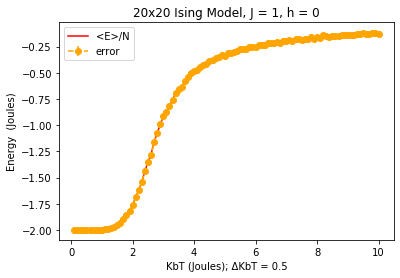

In [4]:
pyplot.plot(KbT_list,E_t,ls='-',color='red',label = "<E>/N")
pyplot.errorbar(KbT_list,E_t,yerr=[E_standdev,E_standdev], fmt='--o',color='orange',label="error")
pyplot.ylabel("Energy  (Joules)")
pyplot.xlabel("KbT (Joules); ΔKbT = 0.5")
pyplot.title("20x20 Ising Model, J = 1, h = 0")
pyplot.legend()

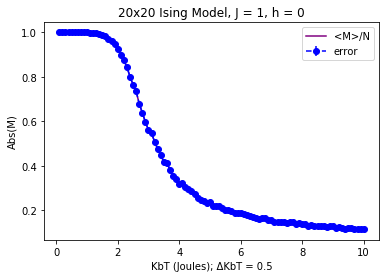

In [5]:

pyplot.plot(KbT_list,M_t,ls='-',color='purple',label = "<M>/N")
pyplot.errorbar(KbT_list,M_t,yerr=[M_standdev,M_standdev], fmt='--o',color='blue',label="error")
pyplot.ylabel("Abs(M)")
pyplot.xlabel("KbT (Joules); ΔKbT = 0.5")
pyplot.title("20x20 Ising Model, J = 1, h = 0")
pyplot.legend()

Text(0.5, 1.0, '20x20 Ising Model, J = 1, h = 0')

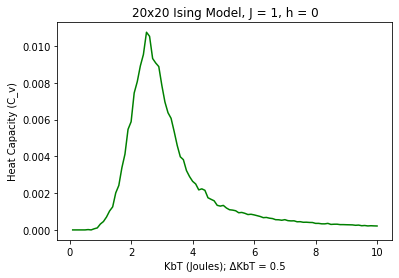

In [6]:
pyplot.plot(KbT_list,((Esq_t-E_t**2)/(KbT_list)**2),ls='-',color='green')
pyplot.ylabel("Heat Capacity (C_v)")
pyplot.xlabel("KbT (Joules); ΔKbT = 0.5")
pyplot.title("20x20 Ising Model, J = 1, h = 0")

Text(0.5, 1.0, '20x20 Ising Model, J = 1, h = 0')

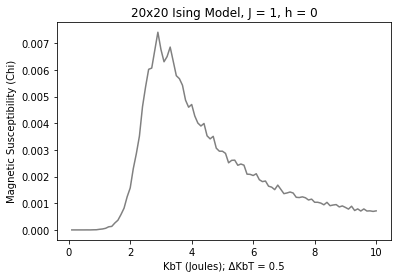

In [7]:
pyplot.plot(KbT_list,((Msq_t-M_t**2)/(KbT_list)),ls='-',color='grey')
pyplot.ylabel("Magnetic Susceptibility (Chi)")
pyplot.xlabel("KbT (Joules); ΔKbT = 0.5")
pyplot.title("20x20 Ising Model, J = 1, h = 0")

In [8]:
print("The maximum C_v occurs at KbT =",KbT_list[np.argmax(((Esq_t-E_t**2)/(KbT_list)**2))],"+- 0.1")
print("The maximum χ occurs at KbT =",KbT_list[np.argmax(((Msq_t-M_t**2)/(KbT_list)**2))],"+- 0.1")

The maximum C_v occurs at KbT = 2.5000000000000004 +- 0.1
The maximum χ occurs at KbT = 2.9000000000000004 +- 0.1


So we can make a guess that the Curie Temperature might be around (2.5 x Kb). Landau states that the analytical solution for the 2D Ising model predicts a Curie Temperature of Tc = 2.27/Kb. Landau also shows results for a 40,000 spin lattice which determine the Curie Temperature to be Tc = 2.5/Kb, so our result seems very reasonable for a 100 spin lattice.

Now let's run a simulation to find the Energy and Magnetization as functions of iteration at values of KbT both above and below KbT = 2.6 J to see the difference.

In [9]:
"""
Here we will initialize an Ising model with L = 10. 
We then run the metropolis algorithm for 100 runs with 1000 steps each
"""
tick()

#L = 10, Run the metropolis algorithm with 1000 steps
L = 10
N_Lattice = L*L #number of lattice sites
N_Iterations = 10*N_Lattice # Number of times to run 
N_deCorrelation = 3 # Number of times to run metropolis algorithm each iteration - to decorrelate the configuration energies
KbT = 2. # Joules
J = 1. #for testing simplicity
h = 0

#Now we generate a 2D Ising model
My_Ising2D = Ising2D(L,J,KbT,h)

#Initialize Energies and Magnetizations
E = np.zeros(N_Iterations)
M = np.zeros(N_Iterations)

#Run metropolis algorithm to initialize a random starting config
for i in range(N_Lattice):
    My_Ising2D.Metropolis()

#Or we can start from all up or all down:
#My_Ising2D.spins.fill(1)
#My_Ising2D.spins.fill(-1)

#Run metropolis algorithm N_Iterations times
n_accepted_configs = 0
for i in range(N_Iterations):
    for j in range(N_deCorrelation): 
        n_accepted_configs += My_Ising2D.Metropolis()  #add number of changes of each Metropolis run
    
    #store Energy and Magnetization for each run
    E[i] = My_Ising2D.E 
    M[i] = abs(My_Ising2D.M_total)
    
#Divide total E and M by number of lattice points to avg
E /= My_Ising2D.N
M /= My_Ising2D.N
E_ferro = E
M_ferro = M
E_total = np.sum(E)/N_Iterations
Esq_total = np.sum(E**2)/N_Iterations
M_total = np.sum(M)/N_Iterations
Msq_total = np.sum(M**2)/N_Iterations

print("2D Ising Simulation with L =",L,", J =",J,", at KbT =", KbT,":")
print("")
print("Expectation Values:")
print("<E>/N = ",E_total)
print("<E^2>/N = ",Esq_total)
print("<M>/N = ",M_total)
print("<M^2>/N = ",Msq_total)
print("")
print("Heat Capacity (C) =",(Esq_total-E_total**2)/(KbT)**2)
print("Magnetic Susceptibility (Chi) =",(Msq_total-M_total**2)/(KbT))
#Finally the ratio of accepted configurations to unaccepted
print("Acceptence Ratio =",float(n_accepted_configs)/(My_Ising2D.N*N_Iterations*N_deCorrelation))

toc()

2D Ising Simulation with L = 10 , J = 1.0 , at KbT = 2.0 :

Expectation Values:
<E>/N =  -1.7691599999999998
<E^2>/N =  3.1527312
<M>/N =  0.9280799999999999
<M^2>/N =  0.8643663999999999

Heat Capacity (C) = 0.005701023600000132
Magnetic Susceptibility (Chi) = 0.0015169568000000244
Acceptence Ratio = 0.07232666666666666
Time Passed: 3.3181967735290527 s


Now we can plot the various components of the generated Ising Model as a function of Metropolis steps (iterations)

Text(0.5, 1.0, 'Ferromagnetic KbT = 2 Joules')

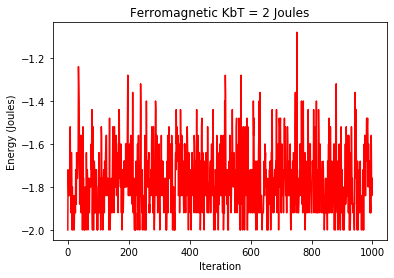

In [10]:
pyplot.plot(range(N_Iterations),E_ferro,color='red')
pyplot.ylabel("Energy (Joules)")
pyplot.xlabel("Iteration")
pyplot.title("Ferromagnetic KbT = 2 Joules")

Text(0.5, 1.0, 'Ferromagnetic KbT = 2 Joules')

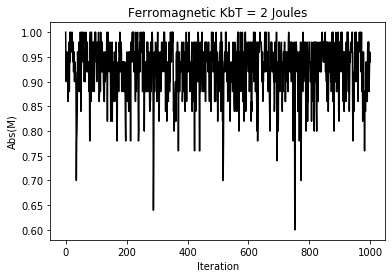

In [11]:

pyplot.plot(range(N_Iterations),M_ferro,color='black')
pyplot.ylabel("Abs(M)")
pyplot.xlabel("Iteration")
pyplot.title("Ferromagnetic KbT = 2 Joules")

Now we can plot our 2D Ising lattice with a colormesh plot where one color represents up spin and the other down spin. We'll be plotting the most recent configuration that we generated

Text(0.5, 1.0, 'Ferromagnetic KbT = 2 Joules')

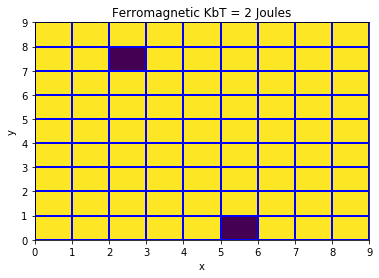

In [12]:

#First generate our lattice
x_k,y_k = np.meshgrid(range(0,My_Ising2D.L),range(0,My_Ising2D.L))

#Then collect and reshape the spins:
spins_plt = My_Ising2D.spins.reshape(My_Ising2D.L,My_Ising2D.L)

#Now we can plot the colormesh:
pyplot.pcolormesh(x_k,y_k,spins_plt,shading='flat',color='b')
pyplot.ylabel("y")
pyplot.xlabel("x")
pyplot.title("Ferromagnetic KbT = 2 Joules")

We can clearly see that for KbT < 2.6 = (Tc x Kb) J, the equilibrium state is a ferromagnet with most spins pointing the same direction

Now for the fun part; We can animate our Ising model as it goes through the Metropolis algorithm iterations!

<IPython.core.display.Javascript object>


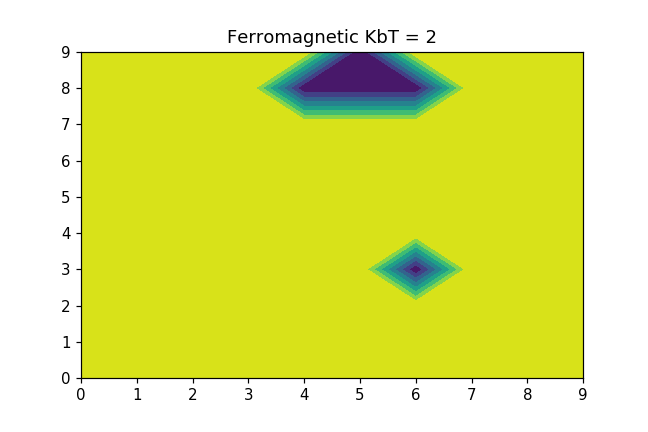

In [14]:
#First I will attempt to animate within the Jupyter notebook:
%matplotlib notebook
from matplotlib import pyplot
import matplotlib.animation as animation

figure, axis = pyplot.subplots()
x_k,y_k = np.meshgrid(range(0,My_Ising2D.L),range(0,My_Ising2D.L))
axis = pyplot.axes(xlim=(0, My_Ising2D.L-1), ylim=(0, My_Ising2D.L-1))
spin_lattice = My_Ising2D.spins.reshape(My_Ising2D.L,My_Ising2D.L)
contour = axis.contourf(x_k,y_k,spin_lattice)

def evolve(k):
    global x_k, y_k, My_Ising2D
    #Run algorithm
    My_Ising2D.Metropolis()
    #Arrange spins
    spin_lattice = My_Ising2D.spins.reshape(My_Ising2D.L,My_Ising2D.L)
    #create contours
    contour = axis.contourf(x_k,y_k,spin_lattice)
    return contour,

Animation = animation.FuncAnimation(figure,evolve,frames = 30,interval=100,blit = False)
pyplot.title("Ferromagnetic KbT = 2")
pyplot.show()

Now we can do the same for KbT > 2.6 = (Tc x Kb) J where we will no longer have ferromagnetism; the system has too much energy for ordered spin chains

In [2]:
%matplotlib inline
from matplotlib import pyplot
"""
Here we will initialize an Ising model with L = 10. 
We then run the metropolis algorithm for 100 runs with 1000 steps each
"""
tick()

#L = 10, Run the metropolis algorithm with 1000 steps
L = 10
N_Lattice = L*L #number of lattice sites
N_Iterations = 10*N_Lattice # Number of times to run 
N_deCorrelation = 3 # Number of times to run metropolis algorithm each iteration - to decorrelate the configuration energies
KbT = 5. # Joules
J = 1. #for testing simplicity
h = 0

#Now we generate a 2D Ising model
My_Ising2D = Ising2D(L,J,KbT,h)

#Initialize Energies and Magnetizations
E = np.zeros(N_Iterations)
M = np.zeros(N_Iterations)

#Run metropolis algorithm to initialize a random starting config
for i in range(N_Lattice):
    My_Ising2D.Metropolis()

#Or we can start from all up or all down:
#My_Ising2D.spins.fill(1)
#My_Ising2D.spins.fill(-1)

#Run metropolis algorithm N_Iterations times
n_accepted_configs = 0
for i in range(N_Iterations):
    for j in range(N_deCorrelation): 
        n_accepted_configs += My_Ising2D.Metropolis()  #add number of changes of each Metropolis run
    
    #store Energy and Magnetization for each run
    E[i] = My_Ising2D.E 
    M[i] = abs(My_Ising2D.M_total)
    
#Divide total E and M by number of lattice points to avg
E /= My_Ising2D.N
M /= My_Ising2D.N
E_noferro = E
M_noferro = M
E_total = np.sum(E)/N_Iterations
Esq_total = np.sum(E**2)/N_Iterations
M_total = np.sum(M)/N_Iterations
Msq_total = np.sum(M**2)/N_Iterations

print("2D Ising Simulation with L =",L,", J =",J,", at KbT =", KbT,":")
print("")
print("Expectation Values:")
print("<E>/N = ",E_total)
print("<E^2>/N = ",Esq_total)
print("<M>/N = ",M_total)
print("<M^2>/N = ",Msq_total)
print("")
print("Heat Capacity (C) =",(Esq_total-E_total**2)/(KbT)**2)
print("Magnetic Susceptibility (Chi) =",(Msq_total-M_total**2)/(KbT))
#Finally the ratio of accepted configurations to unaccepted
print("Acceptence Ratio =",float(n_accepted_configs)/(My_Ising2D.N*N_Iterations*N_deCorrelation))

toc()

2D Ising Simulation with L = 10 , J = 1.0 , at KbT = 5.0 :

Expectation Values:
<E>/N =  -0.32136000000000003
<E^2>/N =  0.1398272
<M>/N =  0.22816000000000003
<M^2>/N =  0.0664984

Heat Capacity (C) = 0.0014621980159999998
Magnetic Susceptibility (Chi) = 0.0028882828799999967
Acceptence Ratio = 0.7741266666666666
Time Passed: 3.139305353164673 s


Now we can plot the various components of the generated Ising Model as a function of Metropolis steps (iterations)

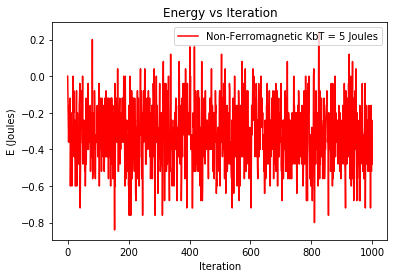

In [16]:
pyplot.plot(range(N_Iterations),E_noferro,color='red',label="Non-Ferromagnetic KbT = 5 Joules")
pyplot.ylabel("E (Joules)")
pyplot.xlabel("Iteration")
pyplot.title("Energy vs Iteration")
pyplot.legend()

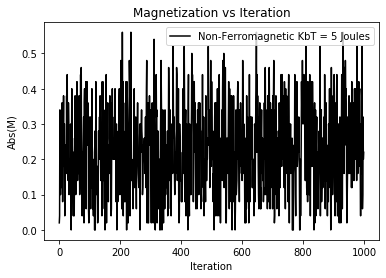

In [17]:

pyplot.plot(range(N_Iterations),M_noferro,color='black',label="Non-Ferromagnetic KbT = 5 Joules")
pyplot.ylabel("Abs(M)")
pyplot.xlabel("Iteration")
pyplot.title("Magnetization vs Iteration")
pyplot.legend()

Now we can plot our 2D Ising lattice with a colormesh plot where one color represents up spin and the other down spin. We'll be plotting the most recent configuration that we generated

Text(0.5, 1.0, 'Non-Ferromagnetic KbT = 5 Joules')

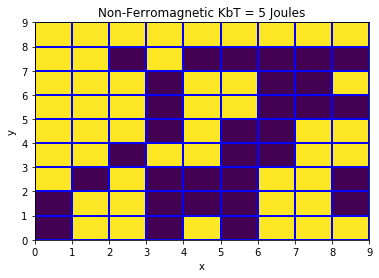

In [18]:

#First generate our lattice
x_k,y_k = np.meshgrid(range(0,My_Ising2D.L),range(0,My_Ising2D.L))

#Then collect and reshape the spins:
spins_plt = My_Ising2D.spins.reshape(My_Ising2D.L,My_Ising2D.L)

#Now we can plot the colormesh:
pyplot.pcolormesh(x_k,y_k,spins_plt,shading='flat',color='b')
pyplot.ylabel("y")
pyplot.xlabel("x")
pyplot.title("Non-Ferromagnetic KbT = 5 Joules")

We can clearly see that for KbT < 2.6 = (Tc x Kb) J, the equilibrium state is a ferromagnet with most spins pointing the same direction

Now for the fun part; We can animate our Ising model as it goes through the Metropolis algorithm iterations!

<IPython.core.display.Javascript object>


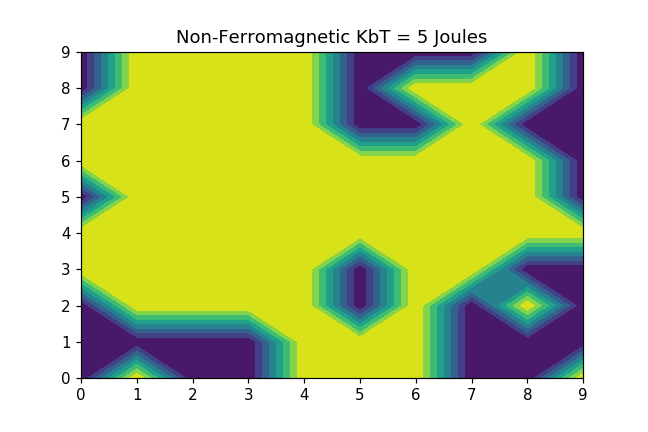

In [5]:
#First I will attempt to animate within the Jupyter notebook:
%matplotlib notebook
from matplotlib import pyplot
import matplotlib.animation as animation

figure, axis = pyplot.subplots()
x_k,y_k = np.meshgrid(range(0,My_Ising2D.L),range(0,My_Ising2D.L))
axis = pyplot.axes(xlim=(0, My_Ising2D.L-1), ylim=(0, My_Ising2D.L-1))
spin_lattice = My_Ising2D.spins.reshape(My_Ising2D.L,My_Ising2D.L)
contour = axis.contourf(x_k,y_k,spin_lattice)

def evolve(k):
    global x_k, y_k, My_Ising2D
    #Run algorithm
    My_Ising2D.Metropolis()
    #Arrange spins
    spin_lattice = My_Ising2D.spins.reshape(My_Ising2D.L,My_Ising2D.L)
    #create contours
    contour = axis.contourf(x_k,y_k,spin_lattice)
    return contour,
Animation = animation.FuncAnimation(figure,evolve,frames = 100,interval=100,blit = False)
pyplot.title("Non-Ferromagnetic KbT = 5 Joules")
pyplot.show()

Now let's plot the Energies and Magnetizations together

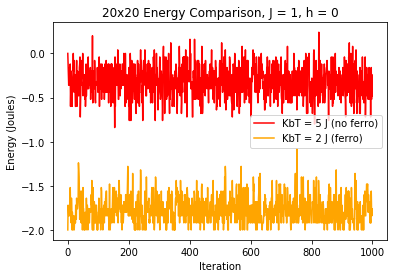

In [21]:
%matplotlib inline
from matplotlib import pyplot
pyplot.plot(range(N_Iterations),E_noferro,color='red',label = "KbT = 5 J (no ferro)")
pyplot.plot(range(N_Iterations),E_ferro,color='orange',label = "KbT = 2 J (ferro)")
pyplot.ylabel("Energy (Joules)")
pyplot.xlabel("Iteration")
pyplot.title("20x20 Energy Comparison, J = 1, h = 0")
pyplot.legend()

So there is lower energy at lower KbT, as it should be

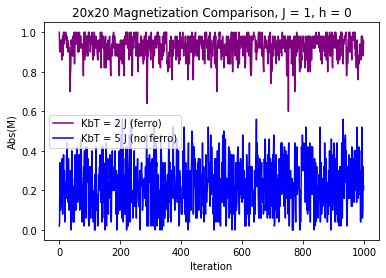

In [23]:
pyplot.plot(range(N_Iterations),M_ferro,color='purple',label = "KbT = 2 J (ferro)")
pyplot.plot(range(N_Iterations),M_noferro,color='blue',label = "KbT = 5 J (no ferro)")
pyplot.ylabel("Abs(M)")
pyplot.xlabel("Iteration")
pyplot.title("20x20 Magnetization Comparison, J = 1, h = 0")
pyplot.legend()

Recall that M = 1 corresponds to all spins aligned and M -> 0 implies maximum misalignment. This is the behavior we expect